In [66]:
import pickle
import matplotlib.pyplot as plt
from utils import load_net
import glob
import pandas as pd
from sklearn.metrics import precision_recall_curve, auc

In [104]:
def get_nets(directory):
    nets = dict()
    for n in glob.glob(f"{directory}*-voting.pickle"):
        gamma, net = load_net(n)
        nets[gamma] = net
        sizes = [len(n) for g, n in sorted(nets.items())]
    return nets, sizes

In [105]:
stream_dir = '../res/newclusterres/cleans/streamed/'
merged_dir = '../res/newclusterres/cleans/merged/'

In [106]:
nets, sizes = get_nets(directory=stream_dir)
merged_nets, merged_sizes = get_nets(directory=merged_dir)

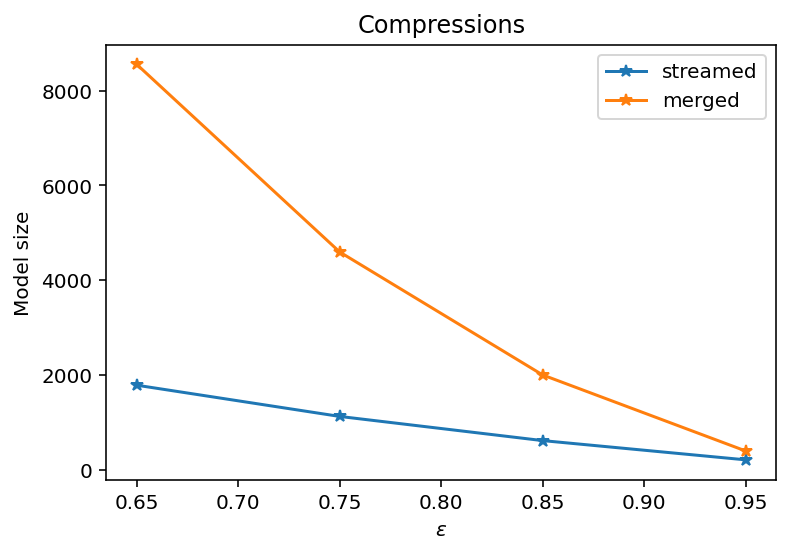

In [107]:
plt.title('Compressions')
plt.plot(sorted(streamed_nets.keys()), sizes,'-*', label='streamed');
plt.plot(sorted(merged_nets.keys()), merged_sizes,'-*', label='merged');

plt.legend()

plt.xlabel('$\epsilon$')
plt.ylabel('Model size');

In [70]:
labels = pd.read_csv('../res/newclusterres/apks_labels_hashed.csv', index_col=0)

def read_and_conv(fname, labels):
    with open(fname, 'rb') as f:
        eres = pickle.load(f)
    tblre = dict()
    for r, val in eres:
        tblre[r['apk']] = [r['nn'], val, not labels.loc[r['apk']]['malware_label']]
    return pd.DataFrame.from_dict(tblre, orient='index', columns=[ 'nearest', 'prob', 'true_val'])



In [112]:
def get_perf(directory, gammas):
    performance = dict()
    for gamma in gammas:
        df = read_and_conv(fname=f"{directory}/{gamma}-evalresults.pickle", labels=labels)
        [p1, r1, thresholds] = precision_recall_curve(df['true_val'], df['prob'])
        performance[gamma] = [p1, r1]
        
    return performance

In [113]:
perf_stream = get_perf(directory=stream_dir, gammas=streamed_nets.keys())
perf_merge = get_perf(directory=merged_dir, gammas=merged_nets.keys())

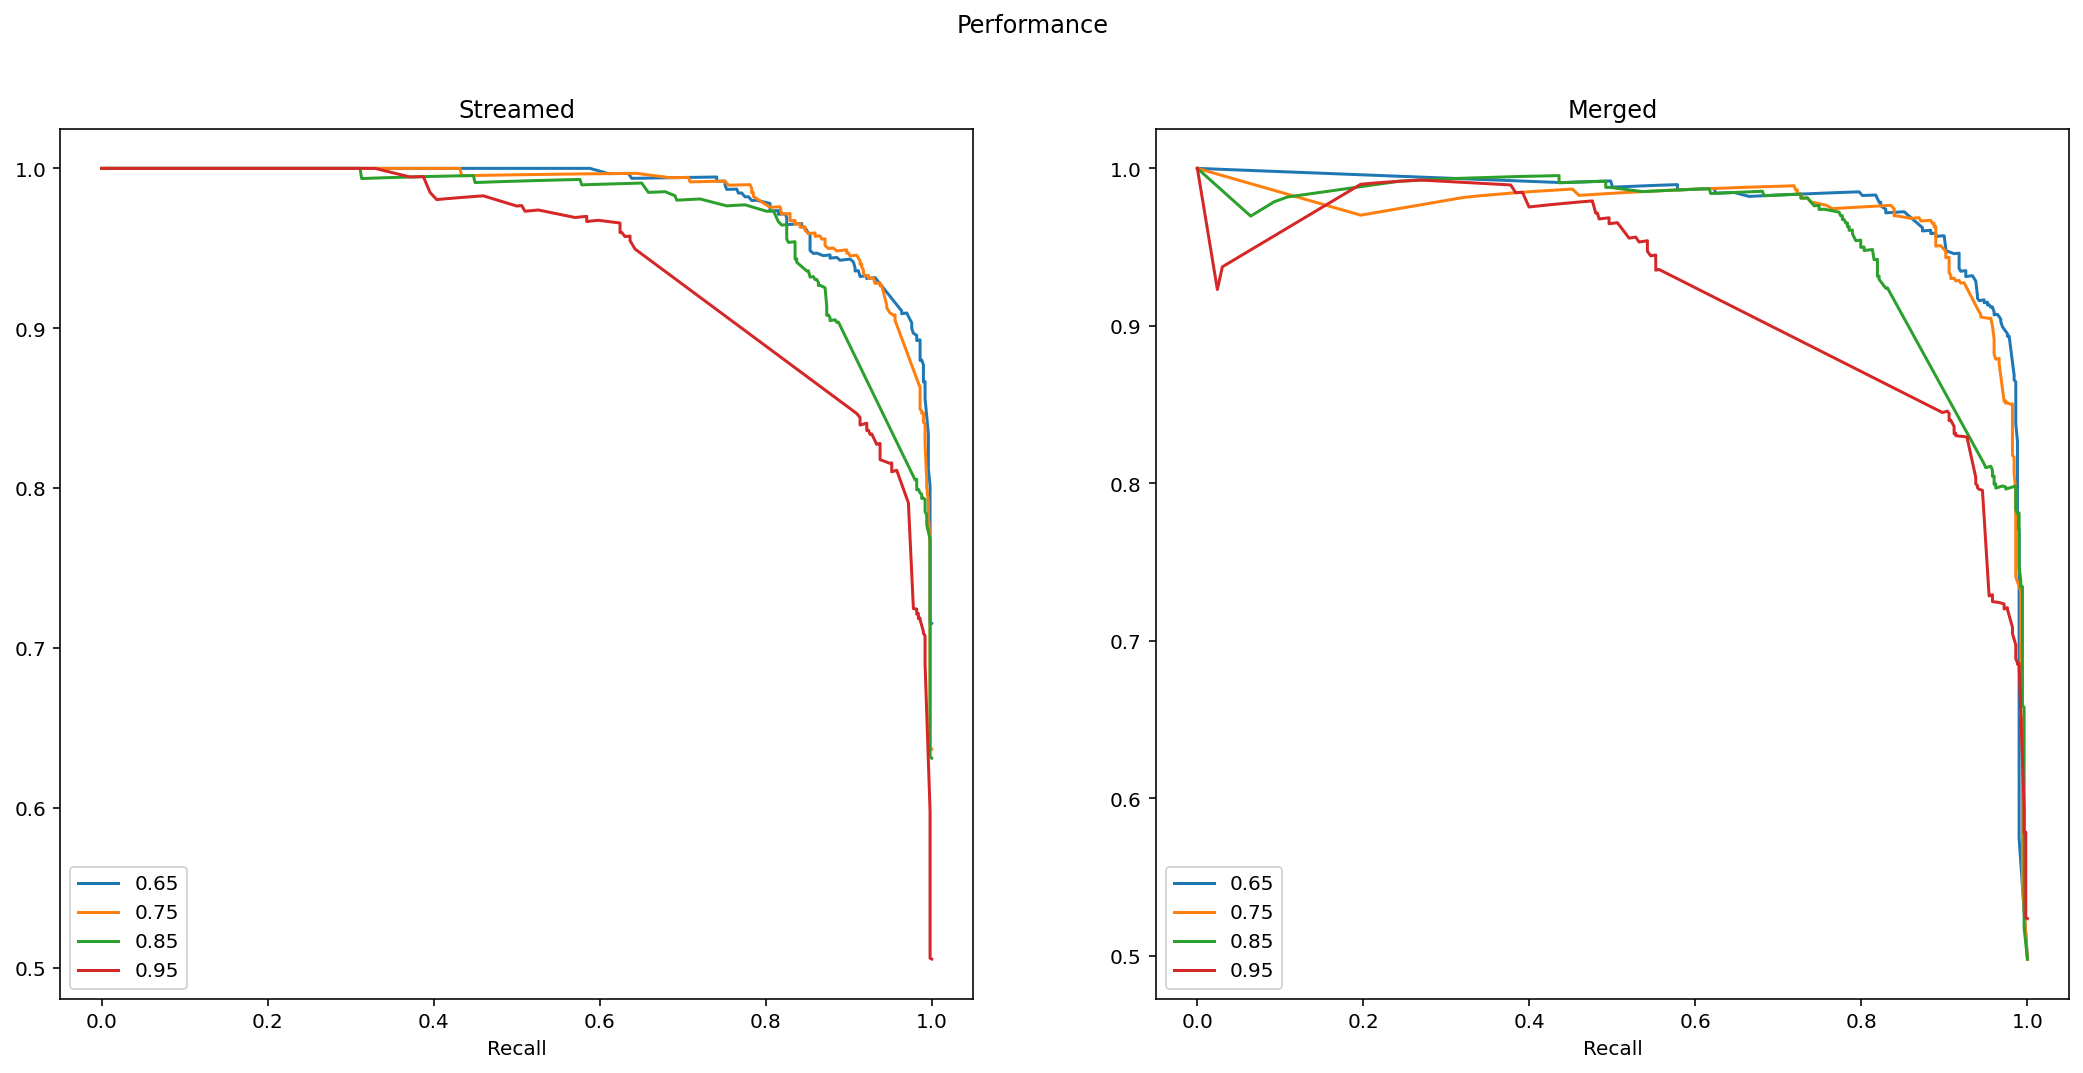

In [121]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,8))
fig.suptitle('Performance')

#plt.title('Performance of streamed network')
for gamma, [p1, r1] in sorted(perf_stream.items()):
    ax1.plot(r1, p1, label=f"{gamma}")
ax1.set_xlabel('Recall')
ax1.set_title('Streamed')
ax1.legend()
    
for gamma, [p1, r1] in sorted(perf_merge.items()):
    ax2.plot(r1, p1, label=f"{gamma}")
ax2.set_title('Merged')
ax2.set_xlabel('Recall')
ax2.legend();



In [122]:
streamed_aucs = {len(streamed_nets[gamma]): auc(r1, p1) for gamma, [p1, r1] in sorted(perf_stream.items())}
merged_aucs = {len(merged_nets[gamma]): auc(r1, p1) for gamma, [p1, r1] in sorted(perf_merge.items())}

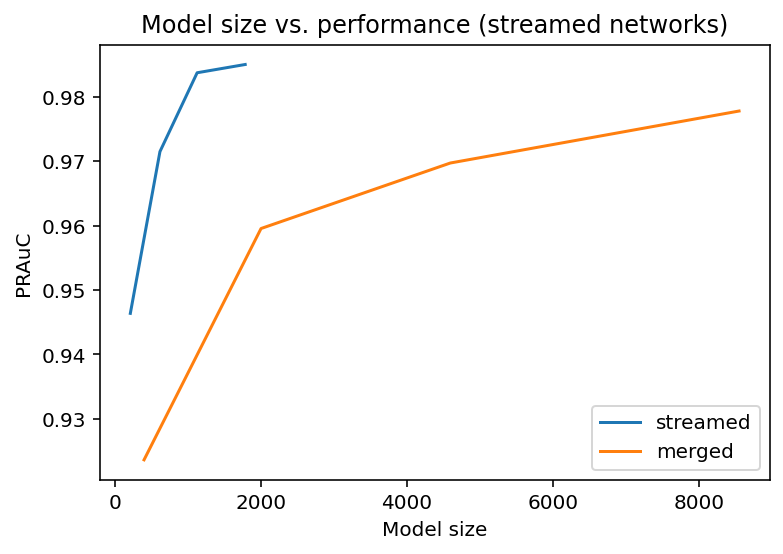

In [123]:
plt.title('Model size vs. performance (streamed networks)')
plt.plot(streamed_aucs.keys(), streamed_aucs.values(), label='streamed')
plt.plot(merged_aucs.keys(), merged_aucs.values(), label='merged')
plt.xlabel('Model size')
plt.legend()
plt.ylabel('PRAuC');